## Table of Contents

1. **Introduction**
    - Upfront Pricing Mechanism
    - Objective of Analysis
    - Analysis Strategy
2. **Exploratory Data Analysis (EDA)**
    - Initial Dataset Overview
    - Handling Missing Data
        - Decisions for Missing Values
    - Feature Engineering
        - Handling Categorical Variables
    - Removal of Irrelevant Columns
3. **Exploratory Data Analysis (EDA) - Continued**
    - Descriptive Statistics
    - Visual Exploration of All Columns
    - Outlier Detection
    - Visualization after Outlier Removal
    - Time-based Analysis
    - Device-based Analysis
    - Destination Change Analysis
    - Predictive Modeling

# Introduction

## Upfront Pricing Mechanism

The upfront pricing model in ride-hailing applications operates on a two-tier system:

1. **Prediction Phase**: The system predicts the cost of a ride based on anticipated distance and time. This predicted price is what users see on their app before confirming a ride.
2. **Adjustment Phase**: If the post-ride metered price (calculated using the actual distance and time) diverges significantly from the predicted price, the system defaults to the metered price. A substantial difference is when the actual cost is more than 20% different from the predicted one.

*Example: For a ride predicted at 5 euros, if the actual metered price is between 4 and 6 euros, the user pays the upfront cost of 5 euros. Otherwise, the metered price is applied.*

## Objective of Analysis

The primary aim is to heighten the precision of the upfront pricing mechanism. This enhancement is pivotal for:

- **User Transparency**: Ensuring customers understand and trust the pricing model.
- **Business Profitability**: Minimizing disparities between predicted and metered prices to ensure operational efficiency.

The dataset at our disposal, `test.csv`, provides detailed insights into individual ride orders, encompassing elements like ride metrics, pricing components, GPS confidence, app version details, compliance indicators, and risk scores.

## Analysis Strategy

1. **Upfront Pricing Accuracy**: Examine the disparity between the upfront and metered prices across rides to pinpoint the main causes of inaccuracies.
2. **Influencing Factors**: Analyze variables like GPS confidence, destination changes, and the reasons for price prediction changes to determine their impact on pricing accuracy.
3. **Operational Improvements**: Look into app versions, device types, and geographical indicators to identify potential operational areas for improvement.
4. **Risk Management**: Assess the fraud score to understand its correlation with price discrepancies.

By adopting a dual approach, catering to both business and technical perspectives, we aim to offer robust, actionable recommendations to fortify the upfront pricing mechanism in ride-hailing applications.

# Exploratory Data Analysis (EDA) - Continued

## Descriptive Statistics

Before any visual exploration, it's always a good idea to look at some summary statistics. This provides us with a snapshot of central tendencies, spread, and the shape of the distribution of the data.

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px

# Loading the dataset
dataset = pd.read_csv("dataset.csv")

# Displaying the first few rows of the dataset
dataset.head()


,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 3:37:31,4.04,10.0,2839,700,1,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 2:26:19,6.09,3.6,5698,493,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 6:34:54,72871.72,NaN,49748,1400,0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


Initially, understanding the basic structure, data types, and identifying any immediate inconsistencies or missing values in the dataset is essential. This helps in framing the preprocessing strategy.

## **2. Handling Missing Data**

Missing data can often mislead or dilute the analytical outcomes. It is crucial to handle them wisely to maintain the integrity and accuracy of the analysis.


In [22]:
# Checking for missing values
missing_data = dataset.isnull().sum()
print("Missing values for each column:\n", missing_data)


Missing values for each column:
 order_id_new                0
order_try_id_new            0
calc_created                0
metered_price              20
upfront_price            1534
distance                    0
duration                    0
gps_confidence              0
entered_by                  0
b_state                     0
dest_change_number          0
prediction_price_type      20
predicted_distance         20
predicted_duration         20
change_reason_pricing    4645
ticket_id_new               0
device_token             4943
rider_app_version          16
order_state                 0
order_try_state             0
driver_app_version          0
driver_device_uid_new       0
device_name                 0
eu_indicator                0
overpaid_ride_ticket        0
fraud_score              2759
dtype: int64


### **2.1 Decisions for Missing Values**

- **`upfront_price`**: Entries without this value are removed as they are not useful for our analysis.
- **`change_reason_pricing`**: Due to its high missingness, this column will be dropped.
- **`fraud_score`**: Missing values are imputed with 0.

Let's execute these decisions in the following code block.


In [23]:
# Dropping rows where upfront_price is missing
dataset = dataset.dropna(subset=['upfront_price'])

# Dropping the column 'change_reason_pricing'
dataset = dataset.drop(columns=['change_reason_pricing'])

# Imputing missing fraud_score with 0
dataset['fraud_score'].fillna(0, inplace=True)

## **3. Feature Engineering**

Enhancing the dataset with new features or modifying existing ones for more profound insights and analysis.


In [24]:
# Calculate percentage difference between Upfront and Metered Price
dataset['price_diff_perc'] = abs(100 * (dataset['upfront_price'] - dataset['metered_price']) / dataset['metered_price'])

# Formatting the date columns for future time-based analysis
dataset['calc_created'] = pd.to_datetime(dataset['calc_created'])
dataset['Order Date'] = dataset['calc_created'].dt.strftime("%Y-%m-%d")
dataset['Hour of Order'] = dataset['calc_created'].dt.strftime("%H")


### **3.1 Handling Categorical Variables**

Certain categorical columns such as 'entered_by' are transformed to make them more suitable for analysis and modelling.


In [25]:
# Handling Categorical Variables by one-hot encoding the 'entered_by' column
dataset = pd.get_dummies(dataset, columns=['entered_by'], drop_first=True)


## **4. Removal of Irrelevant Columns**

Eliminating columns that might not contribute significantly to our analysis.


In [26]:
# Dropping irrelevant columns
dataset = dataset.drop(columns=['device_token', 'ticket_id_new', 'driver_device_uid_new'])


With the data now cleaned and enriched with essential features, it stands ready for a more rigorous and insightful analysis aimed at enhancing upfront pricing precision in the ride-hailing dataset.


# Exploratory Data Analysis (EDA)

Understanding our data is crucial before making any decisions. In this section, we'll explore our dataset from various angles to get a better sense of the underlying structures and patterns.

## 1. Descriptive Statistics

Before any visual exploration, it's always a good idea to look at some summary statistics. This provides us with a snapshot of central tendencies, spread, and the shape of the distribution of the data.

In [27]:
dataset.describe()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,eu_indicator,overpaid_ride_ticket,fraud_score,price_diff_perc,entered_by_driver
count,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000
mean,1773.188325,1773.187445,4999.300109,4160.095747,8971.718979,1245.337342,0.890877,1.060428,8436.150191,1007.584042,0.741273,0.031681,-396.858610,31.096188,0.014960
std,1213.856791,1213.857018,14306.060449,17015.711912,9882.407374,1311.288049,0.311839,0.356673,10972.320329,802.115433,0.438000,0.175175,937.513702,111.719082,0.121412
min,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,21.000000,2.000000,0.000000,0.000000,-14225.000000,0.000000,0.000000
25%,742.000000,742.000000,4.460000,4.200000,3629.000000,537.000000,1.000000,1.000000,3873.000000,552.000000,0.000000,0.000000,-364.000000,4.347826,0.000000
50%,1507.000000,1507.000000,7.370000,6.600000,6549.000000,895.000000,1.000000,1.000000,6365.000000,839.000000,1.000000,0.000000,-10.000000,15.876777,0.000000
75%,2794.000000,2794.000000,2033.300000,4000.000000,11203.000000,1447.000000,1.000000,1.000000,10306.000000,1248.000000,1.000000,0.000000,0.000000,28.945836,0.000000
max,4165.000000,4165.000000,194483.520000,595000.000000,171119.000000,18734.000000,1.000000,7.000000,353538.000000,20992.000000,1.000000,1.000000,49.000000,4248.633214,1.000000


## **2. Visual Exploration of All Columns**

Now, let's visualize the distribution for all numeric columns using histograms. This will give us an initial sense of the data distribution, identify any obvious outliers, and see if any transformations might be needed.


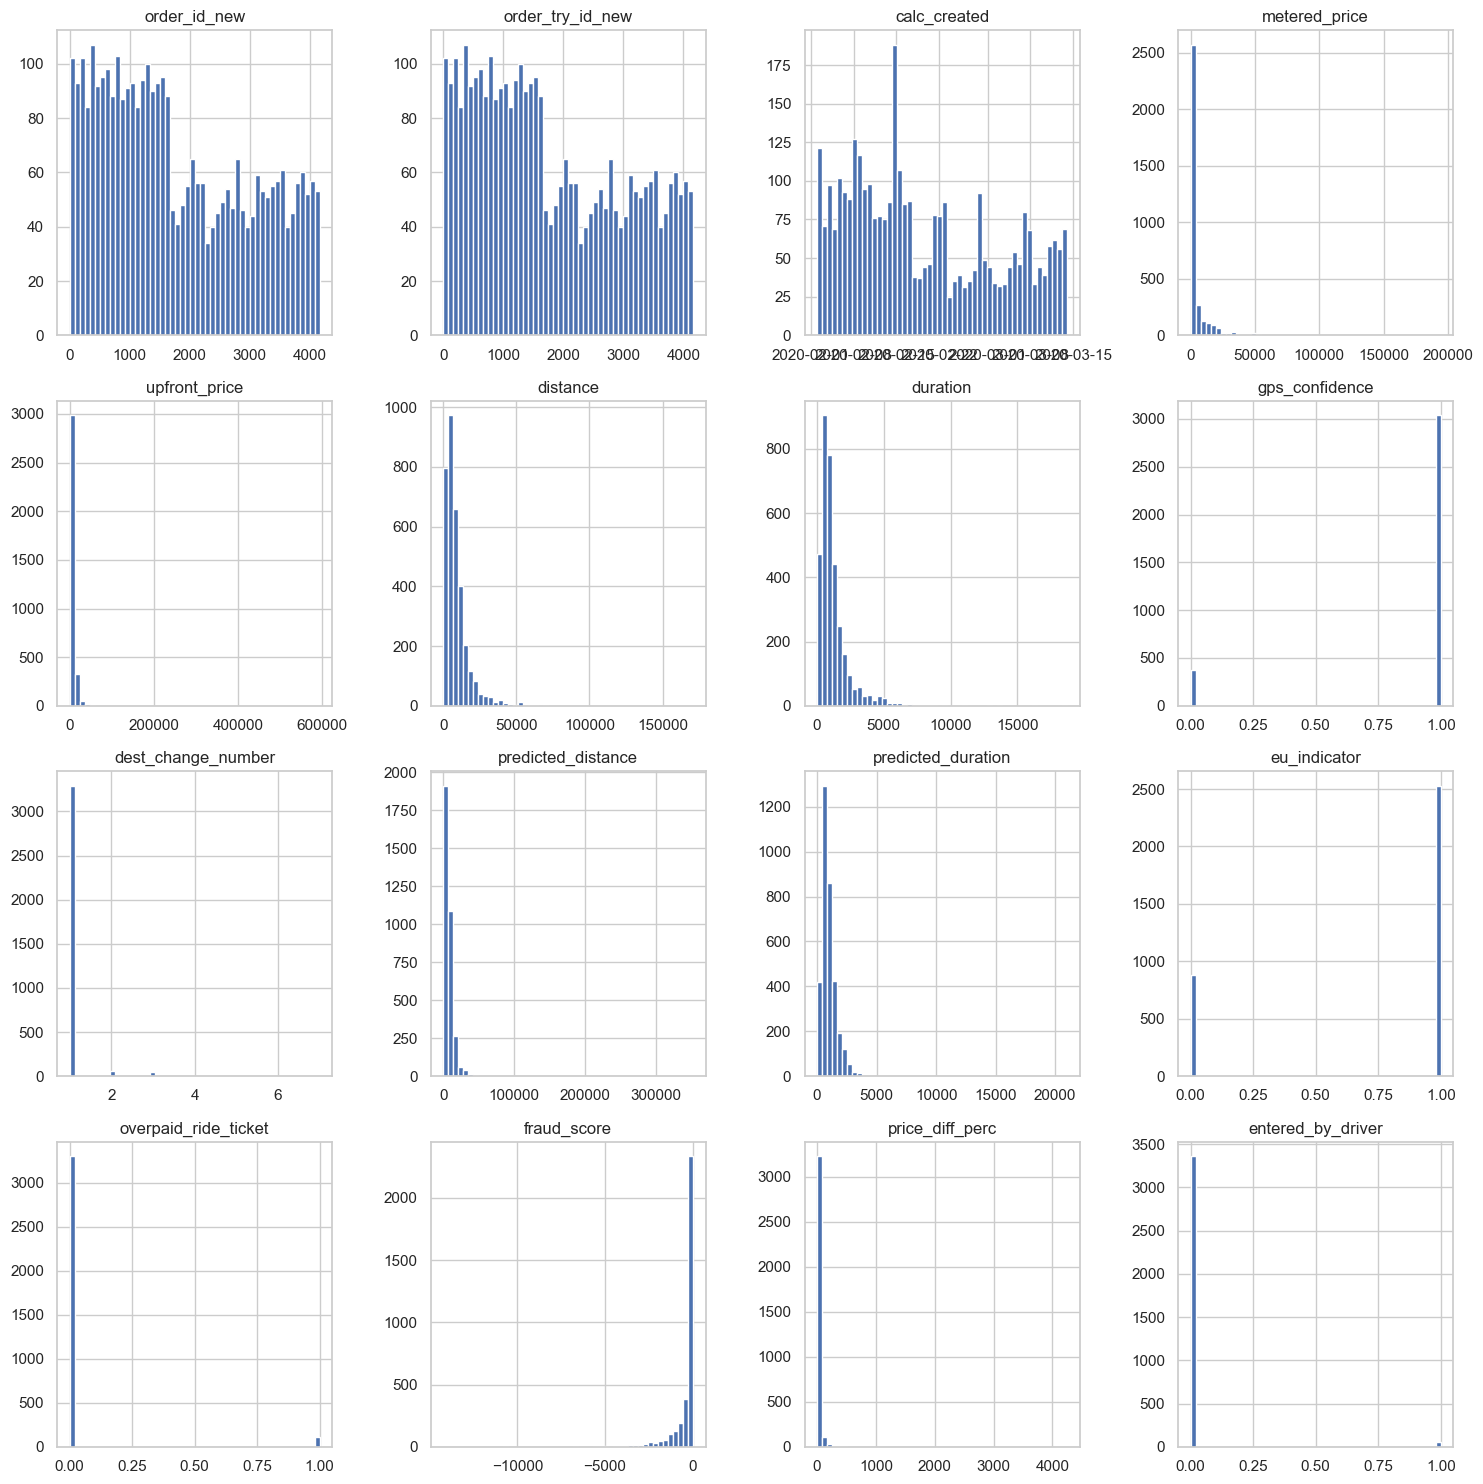

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting style for visualization
sns.set(style="whitegrid")

# Plotting histograms for all numeric columns
dataset.hist(figsize=(15, 15), bins=50)
plt.tight_layout()
plt.show()


## 2. Outlier Detection

For the columns that might contain outliers, we'll use the IQR method. We'll calculate the IQR for each of these columns and determine the lower and upper bounds. Any data point outside of these bounds can be considered an outlier.

Columns to consider:
- metered_price
- upfront_price
- distance
- duration
- predicted_distance
- predicted_duration
- fraud_score
- price_diff_perc


In [29]:
dataset_with_outliers = dataset
# Columns to be considered for outlier detection
cols_to_consider = ['metered_price', 'upfront_price', 'distance', 'duration', 'predicted_distance', 'predicted_duration', 'fraud_score', 'price_diff_perc']

for col in cols_to_consider:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    filter = (dataset[col] >= Q1 - 1.5 * IQR) & (dataset[col] <= Q3 + 1.5 * IQR)
    dataset = dataset[filter]


## 3. Visualization after Outlier Removal

Let's visualize the distributions of the columns after outlier removal to understand the data's shape and spread.


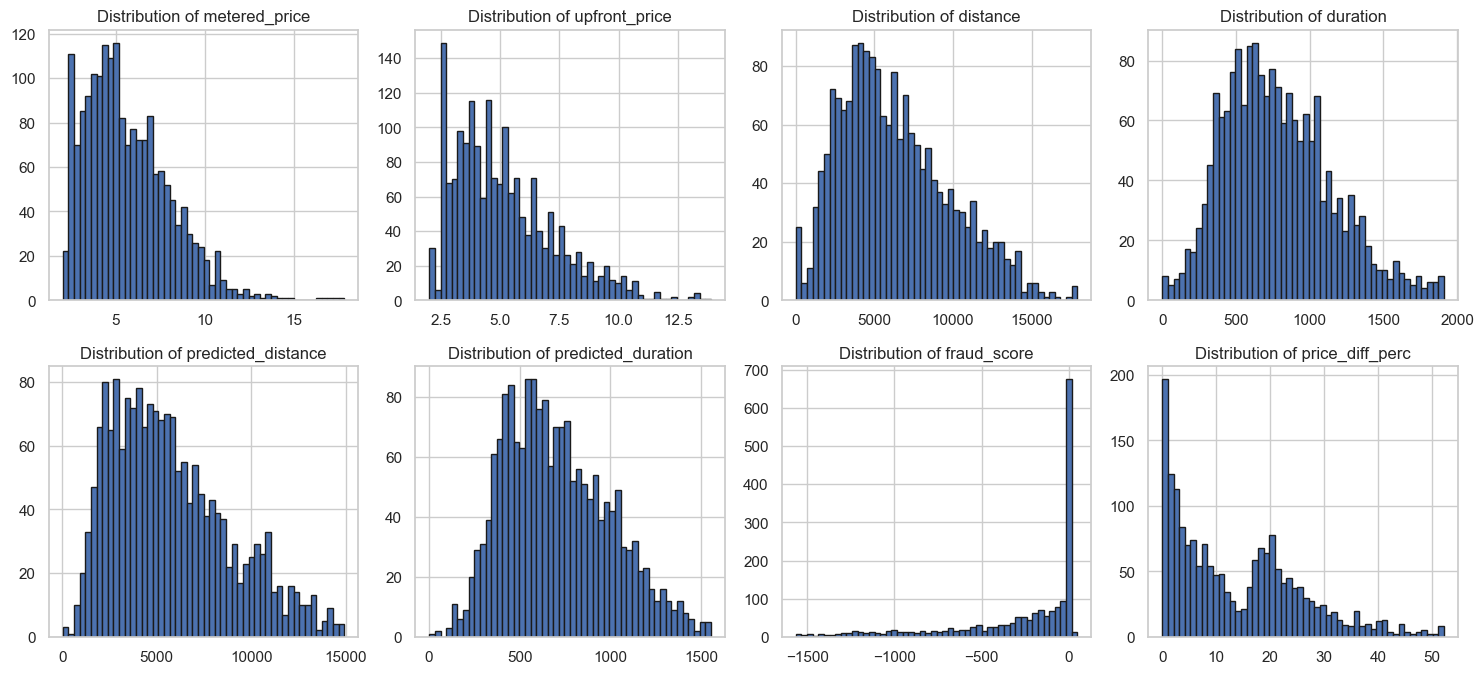

In [30]:
columns_to_plot = ['metered_price', 'upfront_price', 'distance', 'duration', 'predicted_distance', 'predicted_duration', 'fraud_score', 'price_diff_perc']

plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(3, 4, i)
    plt.hist(dataset[col], bins=50, edgecolor='k')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()




### **Key Insights**:

- **Price Distributions**: 
  * Both `metered_price` and `upfront_price` show right-skewed distributions, indicating a higher number of short and lower-priced rides.
  
- **Prediction Accuracy**: 
  * There are noticeable discrepancies between the predicted (`predicted_distance` and `predicted_duration`) and actual values, suggesting the need for further refinement in the prediction models.
  
- **Fraud Score Insights**: 
  * The distribution of `fraud_score` reveals a pronounced spike at 0, indicating a significant portion of riders with limited data, likely new riders or those with few rides. 
  * Negative fraud scores, especially the extreme values like -1500, suggest highly trustworthy riders. The data indicates that there are fewer such trustworthy riders in comparison to those closer to the 0 mark.
  
- **Price Difference**: 
  * The ultimate goal is to ensure that the number of rides where `price_diff_perc` exceeds 20% is minimized. The data shows several instances where this threshold is exceeded, pointing towards inaccuracies in the pricing algorithm.


## Analysis: Raw Data Usage

Using the raw data, without normalization, maintains its original scale and context. This choice ensures we capture all vital information, avoiding distortions or granularity loss from normalization.


Certainly, a simple plot of the metered and upfront prices can reveal that, when we account for outliers or exceptional cases, the upfront pricing algorithm tends to underestimate the prices, meaning it predicts values that are lower than the actual metered prices.

In [31]:
dataset = dataset_with_outliers

fig = px.line(dataset, x=list(range(0, len(dataset))), y=["metered_price", "upfront_price"], title='Deviation between Metered/Upfront Price')
fig.show()


Given that we've generated a column to capture the price differences, we can now perform a groupby operation on various columns within our dataset to identify the primary contributors to prediction discrepancies. By utilizing aggregation functions like count and mean, we can gain insights into which specific values significantly influence the accuracy of upfront pricing.

To start, we can begin by dividing the datapoints into their respective dates and obtaining a rough picture of how many orders and the price deviation per day. As we can see, there is a spike in the number of rides placed every Friday, i.e., in particular on February 14th (Valentine's Day), and a subsequent mean deviation spike on February 16. <font color='green'>This emphasizes the fact that we should adjust the upfront pricing algorithm on holidays/days of importance to account for this mean deviation spike.</green>


In [32]:
grouped_by_date = dataset.groupby(['Order Date'])['price_diff_perc'].agg(['count', 'mean']).reset_index()
grouped_by_date = grouped_by_date.rename(columns={
    "mean": "Mean Deviation (%)",
    "count": "Number of Rides placed"
})

fig = px.line(grouped_by_date, x="Order Date", y=["Mean Deviation (%)", "Number of Rides placed"], title='Upfront and Metered Price Deviation by Date')
fig.show()


Analyzing Hourly Patterns
We'll delve into the hourly patterns as well to investigate whether particular time slots during the day exhibit notable variations.

In [33]:
grouped_by_hour = dataset.groupby(['Hour of Order'])['price_diff_perc'].agg(['count', 'mean']).reset_index()
grouped_by_hour = grouped_by_hour.rename(columns={
    "mean": "Mean Deviation (%)",
    "count": "Number of Orders placed"
})

fig = px.line(grouped_by_hour, x='Hour of Order', y=["Mean Deviation (%)", "Number of Orders placed"], title='Upfront and Metered Price Deviation by Hour')
fig.show()


The data illustrates a significant enhancement in upfront pricing accuracy when GPS Confidence is at level 1. <font color='red'>This observation presents a potential avenue for improvement by either maintaining the GPS Tracker regularly or encouraging users to calibrate their GPS if it's not functioning correctly. In my opinion, this represents a key opportunity for enhancement.</font>

In [34]:
gps_confidence = dataset.groupby(['gps_confidence'])['price_diff_perc'].agg(['count', 'mean']).reset_index()
gps_confidence = gps_confidence.rename(columns={
    "mean": "Mean Deviation (%)",
    "count": "Number of Orders placed"
})
gps_confidence


,gps_confidence,Number of Orders placed,Mean Deviation (%)
0,0,372,68.206941
1,1,3037,26.550518


In this analysis, we observe that devices located within the EU exhibit significantly lower pricing deviations. This phenomenon may be attributed to the superior infrastructure and road network in the EU, which minimizes detours and related factors. <font color='red'>Nonetheless, this underscores the need to concentrate on the non-EU market and explore ways to enhance services there, particularly given that this segment represents a substantial portion of the market.</font>

In [35]:
eu_indicator_stats = dataset.groupby(['eu_indicator'])['price_diff_perc'].agg(['count', 'mean']).reset_index()
eu_indicator_stats


,eu_indicator,count,mean
0,0,882,58.234135
1,1,2527,21.624217


Analysis of Device Manufacturers
We need to assess whether specific device manufacturers demonstrate variations in upfront pricing.

We can now generate a bubble chart, which is effective for visualizing three-dimensional data on a two-dimensional plane. In this chart, the bubble size corresponds to the number of cases. <font color='red'>Notably, we observe that TECNO stands out as a significant contributor, with numerous cases and a notably high mean upfront price deviation from the metered price. This finding warrants further investigation to understand why this specific brand is consistently producing inaccurate upfront price calculations.</font>

In [36]:
dataset['Device Manufacturer'] = dataset['device_name'].str.split(' ').str[0]
device_manufacturer = dataset.groupby(['Device Manufacturer'])['price_diff_perc'].agg(['count', 'mean']).reset_index().sort_values(["mean"], ascending=False)
device_manufacturer = device_manufacturer.rename(columns={
    "mean": "Mean Deviation (%)",
    "count": "Number of Rides placed"
})


fig = px.scatter(device_manufacturer, x='Device Manufacturer', y="Mean Deviation (%)", size='Number of Rides placed', title='Upfront and Metered Price Deviation by Device Manufacturer')
fig.show()
device_manufacturer


,Device Manufacturer,Number of Rides placed,Mean Deviation (%)
21,INFINIX-X551,1,358.333333
24,Itel,41,148.352153
33,OUKITEL,1,116.000000
9,DIGMA,2,77.321429
43,TECNO-J8,18,63.983494
...,...,...,...
67,"iPhone6,1",2,4.055584
8,Coolpad,1,3.614458
25,JUST5,3,3.079054
49,Ulefone,3,0.000000


A change in destination occurring twice results in a notable upfront price deviation. It's important to note that the ability to modify destinations is a fundamental feature, and there may be limited options for addressing this issue. Nevertheless, this observation provides valuable insight.

In [37]:
dest_change_stats = dataset.groupby(['dest_change_number'])['price_diff_perc'].agg(['count', 'mean']).reset_index()
dest_change_stats


,dest_change_number,count,mean
0,1,3288,28.131367
1,2,56,200.111876
2,3,54,36.693025
3,4,6,38.651155
4,5,3,2.714264
5,7,2,41.616271


As an intriguing observation, it appears that iPhone users exhibit a lower upfront price deviation compared to Android users. Investigating the reasons behind this difference could be a valuable pursuit. However, it's worth considering that this variation might also be influenced by the inherent randomness within the dataset.

In [38]:
dataset[['rider_os', 'rider_version']] = dataset['rider_app_version'].str.split('.', 1, expand=True)
rider_os_stats = dataset.groupby(['rider_os'])['price_diff_perc'].agg(['count', 'mean']).reset_index()
rider_os_stats


C:\Users\rando\AppData\Local\Temp\ipykernel_22808\2397677433.py:1: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.



,rider_os,count,mean
0,CA,1826,34.997223
1,CI,1583,26.596321


Predictive Modeling Approach
In the last phase of our analysis, we will explore the application of a Decision Tree Regressor to predict the metered price. This approach aims to determine whether a machine learning model can effectively mitigate pricing deviations.

In [39]:
prediction_dataset = dataset[['predicted_distance','predicted_duration','metered_price','eu_indicator','gps_confidence','fraud_score']]
prediction_dataset = prediction_dataset.dropna()

X = prediction_dataset[['predicted_distance','predicted_duration','eu_indicator','gps_confidence','fraud_score']]
Y = prediction_dataset[['metered_price']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1, random_state=1)

from sklearn.tree import DecisionTreeRegressor
DT_model = DecisionTreeRegressor(max_depth=10).fit(X_train,Y_train)
DT_predict = DT_model.predict(X_test) #Predictions on Testing data

prediction = DT_predict.ravel()

Testing = Y_test.to_numpy().ravel()

print ("This is the accuracy from my machine learning model = ",abs((prediction - Testing)/Testing * 100).mean(), "%")
print("This is the upfront and metered price deviation from the original dataset = ",dataset["price_diff_perc"].mean(), "%")

This is the accuracy from my machine learning model =  39.86467392438026 %
This is the upfront and metered price deviation from the original dataset =  31.096187787756698 %


In [40]:
import plotly.graph_objs as go

# Get feature importances from the trained Decision Tree model
feature_importances = DT_model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a heatmap trace
heatmap_trace = go.Heatmap(
    x=feature_importance_df['Feature'],
    y=['Feature Importance'],
    z=[feature_importance_df['Importance']],
    colorscale='Viridis',
    colorbar=dict(title='Importance')
)

# Create a layout for the heatmap
heatmap_layout = go.Layout(
    title='Feature Importance Heatmap',
    xaxis=dict(title='Features'),
    yaxis=dict(showticklabels=False)
)

# Create a figure and plot the heatmap
heatmap_fig = go.Figure(data=[heatmap_trace], layout=heatmap_layout)
heatmap_fig.show()
